In [18]:
import os
from glob import glob
import platform
import torch
import random
import numpy as np
import subprocess
import json
from tqdm import tqdm
import shapeworks as sw
import DataAugmentationUtils
import DeepSSMUtils
import math
import shutil

# Load Images

In [4]:
torch.multiprocessing.set_sharing_strategy('file_system')
if platform.system() == "Darwin":
    os.environ['OMP_NUM_THREADS'] = "1"

In [5]:
city = 'All'
size = 64
vent = 3
dataset_directory = f'../dataset/{city}/Ventricles_{size}_{vent}_cleaned/'
deepssm_directory = f'{dataset_directory}DeepSSM_inc/'
groom_directory = f'{deepssm_directory}groomed/'
mesh_directory = f'{deepssm_directory}mesh/'
aug_directory = f'{deepssm_directory}augmentation/'
loader_directory = f'{deepssm_directory}torch_loaders/'

val_test_images_directory = f'{groom_directory}val_and_test_images/'
val_paticle_directory = f'{groom_directory}validation_particles/'

for directory in [
    deepssm_directory, mesh_directory, groom_directory, aug_directory, loader_directory,
    val_test_images_directory, val_paticle_directory
]:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [6]:
image_paths = sorted(glob(f'{dataset_directory}*.nrrd'))
uids = [image_path.split('/')[-1][:5] for image_path in image_paths]

In [7]:
images = [sw.Image(image_path) for image_path in image_paths]

In [8]:
meshes = [image.toMesh(isovalue=0.5) for image in images]
sw.utils.save_meshes(
    outDir=mesh_directory,
    swMeshList=meshes,
    swMeshNames=uids,
    extension='ply',
    verbose=False
);

In [9]:
mesh_paths = sorted(glob(f'{mesh_directory}*.ply'))

# Define Split

In [10]:
train_val_test_ratio = (0.9, 0.1, 0)
assert sum(train_val_test_ratio) == 1

total_size = len(image_paths)
val_size = int(total_size * train_val_test_ratio[1])
test_size = int(total_size * train_val_test_ratio[2])
train_size = total_size - val_size - test_size

print(f'Train:      {train_size}')
print(f'Validation: {val_size}')
print(f'Test:       {test_size}')

Train:      981
Validation: 109
Test:       0


In [11]:
# random.seed(0)
indices = list(range(total_size))
# random.shuffle(indices)
all_indices = {
    'train': sorted(indices[:train_size]),
    'val': sorted(indices[train_size:train_size+val_size]),
    'test': sorted(indices[train_size+val_size:])
}
all_indices;

In [12]:
all_image_paths, all_mesh_paths, all_images, all_meshes, all_uids = dict(), dict(), dict(), dict(), dict()
for mode in ['train', 'val', 'test']:
    all_image_paths[mode] = [image_paths[i] for i in all_indices[mode]]
    all_mesh_paths[mode] = [mesh_paths[i] for i in all_indices[mode]]
    all_images[mode] = [images[i] for i in all_indices[mode]]
    all_meshes[mode] = [meshes[i] for i in all_indices[mode]]
    all_uids[mode] = [uids[i] for i in all_indices[mode]]

# Training Mesh Transforms

In [13]:
ref_index = 25#sw.find_reference_mesh_index(all_meshes['train'])# Bal-0 Beijing-3 All-25
ref_mesh = all_meshes['train'][ref_index].copy()
ref_translate = ref_mesh.center()
ref_mesh.translate(-ref_translate)
ref_mesh.write(f'{mesh_directory}reference.vtk')
ref_index

25

In [14]:
train_rigid_transforms = []
for train_mesh in tqdm(all_meshes['train']):
    rigid_transform = train_mesh.createTransform(
        target=ref_mesh, 
        align=sw.Mesh.AlignmentType.Rigid, 
        iterations=100
    )
    train_mesh.applyTransform(rigid_transform)
    train_rigid_transforms.append(rigid_transform)
    
train_transforms = train_rigid_transforms

100%|██████████| 981/981 [01:34<00:00, 10.42it/s]


# Optimize Training Particles

In [15]:
output_directory = deepssm_directory
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

mesh_files = all_mesh_paths['train']
meshes = all_meshes['train']

distances = np.zeros(len(meshes))
for i in range(len(meshes)):
    distances[i] = np.mean(meshes[i].distance(ref_mesh)[0])

sorted_indices = np.argsort(distances)
sorted_mesh_files = np.array(mesh_files)[sorted_indices]

batch_size = 50
batches = [sorted_mesh_files[i:i + batch_size] for i in range(0, len(sorted_mesh_files), batch_size)]
print(f"Created {len(batches)} batches of size {len(batches[0])}")

Created 20 batches of size 50


In [16]:
# Create project spreadsheet
project_location = output_directory + "shape_models/"
if not os.path.exists(project_location):
    os.makedirs(project_location)
# Remove particle dir if it already exists
shape_model_dir = project_location + 'incremental_supershapes_particles/'
if os.path.exists(shape_model_dir):
    shutil.rmtree(shape_model_dir)
    
# Set subjects
subjects = []
for i in range(len(batches[0])):
    subject = sw.Subject()
    
    subject.set_number_of_domains(1)
    
    rel_mesh_file = sw.utils.get_relative_paths([os.getcwd() + "/" + batches[0][i]], project_location)
    subject.set_original_filenames(rel_mesh_file)
    subject.set_groomed_filenames(rel_mesh_file)
    
    transform = [train_transforms[sorted_indices[i]].flatten()]
    subject.set_groomed_transforms(transform)
    
    subjects.append(subject)
    
# Set project
project = sw.Project()
project.set_subjects(subjects)
parameters = sw.Parameters()
     
# Create a dictionary for all the parameters required by optimization
parameter_dictionary = {
    "number_of_particles": 512,
    "use_normals": 0,
    "normal_weight": 10.0,
    "checkpointing_interval": 300,
    "keep_checkpoints": 0,
    "iterations_per_split": 1000, # 1000
    "optimization_iterations": 1500, # 1000
    "starting_regularization": 200, # 200
    "ending_regularization": 0.1, # 0.1
    "recompute_regularization_interval": 1,
    "domains_per_shape": 1,
    "relative_weighting": 1, # ??
    "initial_relative_weighting": 0.05,
    "procrustes_interval": 0,
    "procrustes_scaling": 0,
    "save_init_splits": 0,
    "verbosity": 1,
    # "multiscale": 1, # unless single-scale
    # "multiscale_particles": 64, # unless single-scale
}

# Add param dictionary to spreadsheet
for key in parameter_dictionary:
    parameters.set(key, sw.Variant([parameter_dictionary[key]]))
parameters.set("domain_type", sw.Variant('mesh'))
project.set_parameters("optimize", parameters)
spreadsheet_file = output_directory + "shape_models/incremental_supershapes.xlsx"
project.save(spreadsheet_file)

True

In [19]:
optimize_cmd = ('shapeworks optimize --name ' + spreadsheet_file).split()
subprocess.check_call(optimize_cmd)

FileNotFoundError: [Errno 2] No such file or directory: 'shapeworks': 'shapeworks'

In [ ]:
parameter_dictionary["use_landmarks"] = 1
parameter_dictionary["iterations_per_split"] = 0
parameter_dictionary["optimization_iterations"] = 500 # fewer optimization iterations
parameter_dictionary["multiscale"] = 0

for batch_index in tqdm(range(1, len(batches))):
    sw.utils.findMeanShape(shape_model_dir)
    mean_shape_path = shape_model_dir + '/meanshape_local.particles'
    
    subjects = []
    for i in range(batch_index):
        for j in range(len(batches[i])):
            subject = sw.Subject()
            
            subject.set_number_of_domains(1)
            
            rel_mesh_file = sw.utils.get_relative_paths([os.getcwd() + "/" + batches[i][j]], project_location)
            subject.set_original_filenames(rel_mesh_file)
            subject.set_groomed_filenames(rel_mesh_file)
            
            transform = [train_transforms[sorted_indices[i * batch_size + j]].flatten()]
            subject.set_groomed_transforms(transform)
            
            particle_file = shape_model_dir + os.path.basename(rel_mesh_file[0]).replace(".ply", "_local.particles")
            rel_particle_file = sw.utils.get_relative_paths([os.getcwd() + "/" + particle_file],  project_location)
            subject.set_landmarks_filenames(rel_particle_file)
            
            subjects.append(subject)
    
    for j in range(len(batches[batch_index])):
        subject = sw.Subject()
        
        subject.set_number_of_domains(1)
        
        rel_mesh_file = sw.utils.get_relative_paths([os.getcwd() + "/" + batches[batch_index][j]], project_location)
        subject.set_original_filenames(rel_mesh_file)
        subject.set_groomed_filenames(rel_mesh_file)
        
        transform = [train_transforms[sorted_indices[batch_index * batch_size + j]].flatten()]
        subject.set_groomed_transforms(transform)
        
        rel_particle_file = sw.utils.get_relative_paths([os.getcwd() + "/" + mean_shape_path],  project_location)
        subject.set_landmarks_filenames(rel_particle_file)
        
        subjects.append(subject)
    
    project = sw.Project()
    project.set_subjects(subjects)
    parameters = sw.Parameters()

    for key in parameter_dictionary:
        parameters.set(key, sw.Variant([parameter_dictionary[key]]))
    parameters.set("domain_type", sw.Variant('mesh'))
    project.set_parameters("optimize", parameters)
    spreadsheet_file = output_directory + "shape_models/incremental_supershapes.xlsx"
    project.save(spreadsheet_file)

    optimize_cmd = ('shapeworks optimize --name ' + spreadsheet_file).split()
    subprocess.check_call(optimize_cmd)

 33%|███▎      | 2/6 [16:31<33:23, 500.98s/it]

In [ ]:
analyze_cmd = ('ShapeWorksStudio ' + spreadsheet_file).split()
subprocess.check_call(analyze_cmd)

## One-time Training

In [13]:
# subjects = []
# for train_mesh_path, train_transform in zip(all_mesh_paths['train'], train_transforms):
#     subject = sw.Subject()
#     subject.set_number_of_domains(1)
    
#     rel_mesh_files = sw.utils.get_relative_paths([train_mesh_path], groom_directory)
#     subject.set_original_filenames(rel_mesh_files)
    
#     rel_groom_files = sw.utils.get_relative_paths([train_mesh_path], groom_directory)
#     subject.set_groomed_filenames(rel_groom_files)
    
#     transform = [train_transform.flatten()]
#     subject.set_groomed_transforms(transform)
    
#     subjects.append(subject)
    
# # Set project
# project = sw.Project()
# project.set_subjects(subjects)

# parameter_dictionary = {
#     "number_of_particles" :               512, #
#     "use_normals" :                       0,
#     "normal_weight" :                     10.0,
#     "checkpointing_interval" :            200,
#     "keep_checkpoints" :                  0,
#     "iterations_per_split" :              2000, #
#     "optimization_iterations" :           1000, #
#     "starting_regularization" :           200, #1000
#     "ending_regularization" :             0.1, #10
#     "recompute_regularization_interval" : 2,
#     "domains_per_shape" :                 1,
#     "relative_weighting" :                1, #10
#     "initial_relative_weighting" :        0.1, #
#     "procrustes" :                        1,
#     "procrustes_interval" :               1,
#     "procrustes_scaling" :                1,
#     "save_init_splits" :                  1,
#     "debug_projection" :                  0,
#     "verbosity" :                         1,
#     "use_statistics_in_init" :            0,
#     "adaptivity_mode" :                   0,
# } 

# parameters = sw.Parameters()
# for key, value in parameter_dictionary.items():
#     parameters.set(key, sw.Variant([value]))
    
# parameters.set("domain_type", sw.Variant('mesh'))
# project.set_parameters("optimize", parameters)

# spreadsheet_file = f'{groom_directory}train.xlsx'
# project.save(spreadsheet_file)

# optimizeCmd = ('shapeworks optimize --name ' + spreadsheet_file).split()
# subprocess.check_call(optimizeCmd)

# analyzeCmd = ('ShapeWorksStudio ' + spreadsheet_file).split()
# subprocess.check_call(analyzeCmd)

True

In [20]:
project = sw.Project()
project.load(spreadsheet_file)

train_alignments = [[float(x) for x in s.split()] for s in project.get_string_column("alignment_1")]
train_alignments = [np.array(x).reshape(4, 4) for x in train_alignments]
train_alignments = [train_alignments[i] for i in np.argsort(sorted_indices)]
train_procrustes = [[float(x) for x in s.split()] for s in project.get_string_column("procrustes_1")]
train_procrustes = [np.array(x).reshape(4, 4) for x in train_procrustes]
train_procrustes = [train_procrustes[i] for i in np.argsort(sorted_indices)]

# train_local_particles = project.get_string_column("local_particles_1")
# train_world_particles = [x.replace("./", groom_directory) for x in project.get_string_column("world_particles_1")]

# Groom Training Images

In [21]:
ref_image = all_images['train'][ref_index].copy()
ref_image.resample([1, 1, 1], sw.InterpolationType.Linear)
ref_image.setOrigin(ref_image.origin() - ref_translate)
ref_image.write(f'{groom_directory}reference_image.nrrd')
ref_procrustes = sw.utils.getITKtransform(train_procrustes[ref_index])

In [22]:
train_transforms = []
# Applying rigid transform
for train_image, train_align, train_proc in tqdm(zip(all_images['train'], train_alignments, train_procrustes), total=train_size):
    train_transform = np.matmul(train_proc, train_align)
    train_transforms.append(train_transform)
    train_image.applyTransform(
        train_transform,
        ref_image.origin(),  
        ref_image.dims(),
        ref_image.spacing(), 
        ref_image.coordsys(),
        sw.InterpolationType.Linear, 
        meshTransform=True
    )

100%|██████████| 19/19 [00:00<00:00, 127.20it/s]


In [23]:
train_image_files = sw.utils.save_images(
    f'{groom_directory}train_images/', 
    all_images['train'],
    [uids[i] for i in all_indices['train']], 
    extension='nrrd',
    verbose=False
)
train_image_files[:5]

['../dataset/Baltimore/Ventricles_64_3_cleaned/DeepSSM/groomed/train_images/17017.nrrd',
 '../dataset/Baltimore/Ventricles_64_3_cleaned/DeepSSM/groomed/train_images/19738.nrrd',
 '../dataset/Baltimore/Ventricles_64_3_cleaned/DeepSSM/groomed/train_images/23750.nrrd',
 '../dataset/Baltimore/Ventricles_64_3_cleaned/DeepSSM/groomed/train_images/23927.nrrd',
 '../dataset/Baltimore/Ventricles_64_3_cleaned/DeepSSM/groomed/train_images/29158.nrrd']

# Augment Data

In [36]:
num_samples = 10
percent_variability = 0.99
sampler_type = 'kde'

embedded_dim = DataAugmentationUtils.runDataAugmentation(
    out_dir=aug_directory,
    img_list=train_image_files, 
    local_point_list=sorted(glob(f'{groom_directory}train_particles/*_local.particles')), 
    num_samples=num_samples, 
    #num_dim,
    percent_variability=percent_variability, 
    sampler_type=sampler_type,
    #mixture_num,
    processes=4, 
    world_point_list=sorted(glob(f'{groom_directory}train_particles/*_world.particles')),
)
print(f'PCA dimensions retained: {embedded_dim}')

Running point based data augmentation.
The PCA modes of particles being retained : 15
Variablity preserved: 0.9917001539148412
Fitting KDE...
Generating 1/10
Generating 2/10
Generating 3/10
Generating 4/10
Generating 5/10
Generating 6/10
Generating 7/10
Generating 8/10
Generating 9/10
Generating 10/10
Done.
PCA dimensions retained: 15


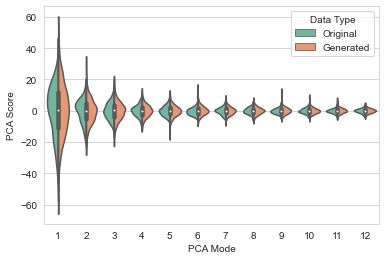

In [5]:
aug_data_csv = aug_directory + 'TotalData.csv'
DataAugmentationUtils.visualizeAugmentation(aug_data_csv, 'violin') # 'splom'

# Find Test and Validation Transforms and Groom Images

In [41]:
# Get reference image
ref_image_file = groom_directory + 'reference_image.nrrd'
ref_image = sw.Image(ref_image_file)
ref_center = ref_image.center() # get center

In [49]:
val_test_image_paths = all_image_paths['val'] + all_image_paths['test']
val_test_mesh_paths = all_mesh_paths['val'] + all_mesh_paths['test']

In [53]:
val_test_image_groomed_paths = []
val_test_transforms = []
for vt_image_path, vt_mesh_path in zip(val_test_image_paths, val_test_mesh_paths):
    vt_image = sw.Image(vt_image_path)
    vt_image_groomed_path = val_test_images_directory + vt_image_path.split('/')[-1]
    val_test_image_groomed_paths.append(vt_image_groomed_path)
    
    transform = np.eye(4)
    
    translation = ref_center - vt_image.center()
    vt_image.setOrigin(vt_image.origin() + translation).write(vt_image_groomed_path)
    transform[:3,-1] += translation
    
    val_test_transforms.append(transform)

In [111]:
val_image_groomed_paths = val_test_image_groomed_paths[:val_size]
val_transforms = val_test_transforms[:val_size]

test_image_groomed_paths = val_test_image_groomed_paths[val_size:]
test_transforms = val_test_transforms[val_size:]

# Optimize Validation Particles with Fixed Domains

In [81]:
val_uids = [uids[i] for i in all_indices['val']]

mean_shape = sum([np.loadtxt(particles) for particles in train_world_particles]) / train_size
np.savetxt(f'{groom_directory}meanshape_world.particles', mean_shape)

In [85]:
subjects = []
# Add fixed training shapes
for train_mesh_path, train_transform, train_local_particle_path in zip(all_mesh_paths['train'], train_transforms, train_local_particles):
    subject = sw.Subject()
    subject.set_number_of_domains(1)
    
    rel_mesh_files = sw.utils.get_relative_paths([train_mesh_path], groom_directory)
    rel_groom_files = sw.utils.get_relative_paths([train_mesh_path], groom_directory)
    
    subject.set_original_filenames(rel_mesh_files)
    subject.set_groomed_filenames(rel_groom_files)
    transform = [train_transform.flatten()]
    
    subject.set_groomed_transforms(transform)
    subject.set_landmarks_filenames([train_local_particle_path])
    subject.set_extra_values({"fixed": "yes"})
    subjects.append(subject)

In [92]:
for val_mesh_path, val_transform, val_uid in zip(all_mesh_paths['val'], val_transforms, all_uids['val']):
    subject = sw.Subject()
    subject.set_number_of_domains(1)
    
    rel_mesh_files = sw.utils.get_relative_paths([val_mesh_path], groom_directory)
    rel_groom_files = sw.utils.get_relative_paths([val_mesh_path], groom_directory)
    
    initial_particles = sw.utils.transformParticles(mean_shape, val_transform, inverse=True)
    initial_particle_file = f'{val_paticle_directory}{val_uid}_local.particles'
    np.savetxt(initial_particle_file, initial_particles)
    
    rel_particle_files = sw.utils.get_relative_paths([initial_particle_file], groom_directory)
    subject.set_original_filenames(rel_mesh_files)
    subject.set_groomed_filenames(rel_groom_files)
    transform = [val_transform.flatten()]
    subject.set_groomed_transforms(transform)
    subject.set_landmarks_filenames(rel_particle_files)
    subject.set_extra_values({"fixed": "no"})
    subjects.append(subject)
    
project = sw.Project()
project.set_subjects(subjects)

In [93]:
parameters = sw.Parameters()

# Update parameter dictionary from step 4
parameter_dictionary["multiscale"] = 0
parameter_dictionary["procrustes"] = 0
parameter_dictionary["procrustes_interval"] = 0
parameter_dictionary["procrustes_scaling"] = 0
parameter_dictionary["use_landmarks"] = 1
parameter_dictionary["use_fixed_subjects"] = 1
parameter_dictionary["narrow_band"] = 1e10
parameter_dictionary["fixed_subjects_column"] = "fixed"
parameter_dictionary["fixed_subjects_choice"] = "yes"
for key, value in parameter_dictionary.items():
    parameters.set(key, sw.Variant(value))
    
project.set_parameters("optimize", parameters)

In [94]:
# Set studio parameters
studio_dictionary = {
    "show_landmarks": 0,
    "tool_state": "analysis"
}
studio_parameters = sw.Parameters()
for key, value in studio_dictionary.items():
    studio_parameters.set(key, sw.Variant(value))
project.set_parameters("studio", studio_parameters)

spreadsheet_file = groom_directory + "validation.xlsx"
project.save(spreadsheet_file)

True

In [96]:
optimize_cmd = ('shapeworks optimize --name ' + spreadsheet_file).split()
subprocess.check_call(optimize_cmd)

0

In [97]:
analyze_cmd = ('ShapeWorksStudio ' + spreadsheet_file).split()
subprocess.check_call(analyze_cmd)

0

In [98]:
val_world_particles = [f'{val_paticle_directory}{val_uid}_world.particles' for val_uid in all_uids['val']]
val_world_particles

['../dataset/Baltimore/Ventricles_256_2/DeepSSM/groomed/validation_particles/19738_world.particles',
 '../dataset/Baltimore/Ventricles_256_2/DeepSSM/groomed/validation_particles/52358_world.particles']

# Create Data Loaders

In [102]:
batch_size = 1
DeepSSMUtils.getTrainLoader(loader_directory, aug_data_csv, batch_size)

********************* WARNING ****************************
Pytorch is running on your CPU!
This will be very slow. If your machine has a GPU,
please reinstall Pytorch to your shapeworks conda 
environment with the correct CUDA version.
**********************************************************
Creating training torch loader...


This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Training loader complete.


In [112]:
DeepSSMUtils.getValidationLoader(loader_directory, val_image_groomed_paths, val_world_particles)

Creating validation torch loader:
Validation names saved to: ../dataset/Baltimore/Ventricles_256_2/DeepSSM/torch_loaders/validation_names.txt
Validation loader complete.


In [113]:
DeepSSMUtils.getTestLoader(loader_directory, test_image_groomed_paths)

Creating test torch loader...
Test names saved to: ../dataset/Baltimore/Ventricles_256_2/DeepSSM/torch_loaders/test_names.txt
Test loader complete.


# Train DeepSSM Model

In [116]:
# Define model parameters
model_name = "DeepSSM_ventricle2"
model_parameters = {
    "model_name": model_name,
    "num_latent_dim": int(embedded_dim),
    "paths": {
        "out_dir": deepssm_directory,
        "loader_dir": loader_directory,
        "aug_dir": aug_directory
    },
    "encoder": {
        "deterministic": True
    },
    "decoder": {
        "deterministic": True,
        "linear": True
    },
    "loss": {
        "function": "MSE",
        "supervised_latent": True,
    },
    "trainer": {
        "epochs": 2, # 10
        "learning_rate": 0.001,
        "decay_lr": False,
        "val_freq": 1
    },
    "fine_tune": {
        "enabled": False,
    },
    "use_best_model": True
}
    
config_file = deepssm_directory + model_name + ".json"
with open(config_file, "w") as outfile:
    json.dump(model_parameters, outfile, indent=2)

In [ ]:
DeepSSMUtils.trainDeepSSM(config_file)

********************* WARNING ****************************
Pytorch is running on your CPU!
This will be very slow. If your machine has a GPU,
please reinstall Pytorch to your shapeworks conda 
environment with the correct CUDA version.
**********************************************************
Loading data loaders...
Done.
Defining net...
Done.
Beginning training on device = cpu

Epoch	  LR	  Train_Err	  Train_Rel_Err	  Val_Err	  Val_Rel_Err	  Sec
Epoch 1/2


# Predict Validation Particles and Analyze Accuracy

In [ ]:
val_out_dir = deepssm_directory + model_name + '/validation_predictions/'
predicted_val_world_particles = DeepSSMUtils.testDeepSSM(config_file, loader='validation')

In [ ]:
local_val_prediction_dir = val_out_dir + 'local_predictions/'
if not os.path.exists(local_val_prediction_dir):
    os.makedirs(local_val_prediction_dir)

In [ ]:
predicted_val_local_particles = []
for particle_file, transform in zip(predicted_val_world_particles, val_transforms):
    particles = np.loadtxt(particle_file)
    local_particle_file = particle_file.replace("FT_Predictions/", "local_predictions/")
    local_particles = sw.utils.transformParticles(particles, transform, inverse=True)
    np.savetxt(local_particle_file, local_particles)
    predicted_val_local_particles.append(local_particle_file)
print("Validation local predictions written to: " + local_val_prediction_dir)

In [ ]:
'''
Analyze validation accuracy in terms of:
- MSE between true and predcited world partcles
- Surface to surface distance between true mesh and mesh generated from predicted local particles
'''
mean_MSE, std_MSE = DeepSSMUtils.analyzeMSE(predicted_val_world_particles, val_world_particles)
print("Validation world particle MSE: "+str(mean_MSE)+" +- "+str(std_MSE))
template_mesh = train_mesh_files[ref_index]
template_particles = train_local_particles[ref_index].replace("./", data_dir)
# Get distabce between clipped true and predicted meshes
mean_dist = DeepSSMUtils.analyzeMeshDistance(predicted_val_local_particles, val_mesh_files, 
                                                template_particles, template_mesh, val_out_dir,
                                                planes=val_planes)
print("Validation mean mesh surface-to-surface distance: "+str(mean_dist))

# Predict Test Particles and Analyze Accuracy

In [ ]:
test_out_dir = output_directory + model_name + '/test_predictions/'
predicted_test_world_particles = DeepSSMUtils.testDeepSSM(config_file, loader='test')
print("Test world predictions saved.")
# Generate local predictions
local_test_prediction_dir = test_out_dir + 'local_predictions/'
if not os.path.exists(local_test_prediction_dir):
    os.makedirs(local_test_prediction_dir)
predicted_test_local_particles = []
for particle_file, transform in zip(predicted_test_world_particles, test_transforms):
    particles = np.loadtxt(particle_file)
    local_particle_file = particle_file.replace("FT_Predictions/", "local_predictions/")
    local_particles = sw.utils.transformParticles(particles, transform, inverse=True)
    np.savetxt(local_particle_file, local_particles)
    predicted_test_local_particles.append(local_particle_file)
print("Test local predictions written to: " + local_test_prediction_dir)
'''
Analyze test accuracy in terms of surface to surface distance between 
clipped true mesh and clipped mesh generated from predicted local particles
'''
mean_dist = DeepSSMUtils.analyzeMeshDistance(predicted_test_local_particles, test_mesh_files, 
                                                template_particles, template_mesh, test_out_dir,
                                                planes=test_planes)
print("Test mean mesh surface-to-surface distance: "+str(mean_dist))